In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Recommendation systems: Deep Model

This model is made up of feature layers that have users, movies and movie genres embedings followed by a neural network with dense layers and finally one output that is the rating prediction that input user(id) could assign to input movie(id).

**Inputs**
* **User id**: Really this is traducet as a sequence because embedding layers only can manage sequenced identifiers.
* **Movie id**: Idem to User id.
* **Movie genres**: One column by genre.

**Output**
*  **Rating prediction** that user could assign to movie.

**Links**
* [Deep Learning With Keras: Recommender Systems](https://www.johnwittenauer.net/deep-learning-with-keras-recommender-systems/)
* [Collaborative Filtering for Movie Recommendations](https://keras.io/examples/structured_data/collaborative_filtering_movielens/)
* [Movie lens datasets](https://grouplens.org/datasets/movielens/)
* [Recommendation Systems Benchmarks](https://paperswithcode.com/task/recommendation-systems)

## Required libraries

In [2]:
import sys
sys.path.append('../src')

import os
from util import create_path, remove_dir

def show_env_var(varname):
    if varname in os.environ:
        print(f'{varname}: {os.environ[varname]}')
    else:
        print(f'{varname} undefined')

In [3]:
user_ray = False

if user_ray:    
    show_env_var('MODIN_OUT_OF_CORE')
    show_env_var('MODIN_MEMORY')
    show_env_var('MODIN_ON_RAY_PLASMA_DIR')

    create_path(os.environ['MODIN_ON_RAY_PLASMA_DIR'])

    import ray
    import modin
    import modin.pandas as pd
    
    modin.__version__

    # ray.shutdown()
    if not ray.is_initialized():
        ray.init(num_cpus=24, num_gpus=1, dashboard_host="0.0.0.0", dashboard_port=8080)
    else:
        print('Ray is already active!')
else:
    import pandas as pd

In [4]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import kerastuner as kt
from util import tf_detected_devices, tf_version, plot_model, Config, LoggerFactory, create_path

from callback import MetricsPlotter
from data import InMemoryXyDataGenerator
from recommendation import UserMovieGenderEmbeddingDenseModelFactory

In [5]:
import logging
tf.get_logger().setLevel(logging.ERROR)

import warnings
warnings.filterwarnings("ignore")

## Logger config

In [6]:
config = Config(path='../config/config.yaml')
LoggerFactory(config['logger']).create()

<RootLogger root (INFO)>

## Check environment

**Step 1**: Make sure that nvidia driver is installed runing next command:

In [7]:
!nvidia-smi --query-gpu=gpu_name,memory.total --format=csv | sed -n 2p

GeForce RTX 3080, 10010 MiB


**Note:** If this shows a GPU model and memory size, that's all right, otherwise make suze that has the nvidia driver installed.

**Step 2**: Let's check tensorflow version:

In [8]:
tf_version()

'Tensorflow version: 2.4.1'

**Step 3**: Let's check devices that tensorflow detect:

In [9]:
tf_detected_devices()

,Name,Device Type,Memory,Description
0,/device:CPU:0,CPU,256M,
1,/device:GPU:0,GPU,8G,"device: 0, name: GeForce RTX 3080, pci bus id:..."


In [10]:
tf.debugging.set_log_device_placement(False)

**Step 4**: Make sure that tensorflow detect cuda libs and GPU devices.

In [11]:
tf.test.is_built_with_cuda()

True

In [12]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Prepare model input data

In [13]:
TEMP_PATH = './temp'
TRAIN_PATH = f'{TEMP_PATH}/train'
VAL_PATH = f'{TEMP_PATH}/val'
TEST_PATH = f'{TEMP_PATH}/test'

train  = False

In [14]:
import glob

def read_csv(path):
    all_files = glob.glob(path)
    li = [pd.read_csv(filename, index_col=None, header=0) for filename in all_files]
    return pd.concat(li, axis=0, ignore_index=True)

In [15]:
train_set = read_csv(f'{TRAIN_PATH}/*.csv')

In [16]:
val_set = read_csv(f'{VAL_PATH}/*.csv')

In [17]:
test_set = read_csv(f'{TEST_PATH}/*.csv')

In [18]:
print(f'Train set size: {"{:,}".format(train_set.shape[0])} samples.')
print(f'Validation set size: {"{:,}".format(val_set.shape[0])} samples.')
print(f'Test set size: {"{:,}".format(test_set.shape[0])} samples.')

Train set size: 70,461 samples.
Validation set size: 21,185 samples.
Test set size: 9,189 samples.


**Step 3:** Let's see min and max value of rating column.

In [19]:
min_rating, max_rating = train_set['rating'].min(), train_set['rating'].max()

print('Rattings:\n - min:', min_rating, '\n - max:', max_rating)

Rattings:
 - min: 0.5 
 - max: 5.0


Calculate train, val batch_size and plot interval.

In [20]:
import math

steps             = 100
epochs            = 80
plot_interval     = math.floor(steps / 2)

train_batch_size  = math.floor(train_set.shape[0] / steps)
val_batch_size    = math.floor(val_set.shape[0] / steps)
evaluate_interval = plot_interval + 1

In [21]:
print(f'Train Batch Size      : {"{:,}".format(train_batch_size)}.')
print(f'Validation Batch Size : {"{:,}".format(val_batch_size)}.')
print('Plot Interval         :', plot_interval)
print('Evaluate Interval     :', evaluate_interval)
print('Epochs                :', epochs)

Train Batch Size      : 704.
Validation Batch Size : 211.
Plot Interval         : 50
Evaluate Interval     : 51
Epochs                : 80


In [22]:
X_train = train_set[list(set(train_set.columns) - set(['user_id', 'movie_id', 'rating']))].values
y_train = train_set['rating'].values

In [23]:
X_val = val_set[list(set(val_set.columns) - set(['user_id', 'movie_id', 'rating']))].values
y_val = val_set['rating'].values

In [24]:
X_test = test_set[list(set(test_set.columns) - set(['user_id', 'movie_id', 'rating']))].values
y_test = test_set['rating'].values

In [25]:
def to_input(X, y): return [X[:, 0], X[:, 1], X[:, 2:22]], y

In [26]:
train_generator = InMemoryXyDataGenerator(
    X_train, 
    y_train, 
    train_batch_size,
    shuffle  = True,
    to_input = to_input
)

In [27]:
batch = train_generator[0]
batch[0][0].shape, batch[0][1].shape, batch[0][2].shape

((704,), (704,), (704, 20))

In [28]:
val_generator = InMemoryXyDataGenerator(
    X_val, 
    y_val, 
    val_batch_size, 
    shuffle  = True,
    to_input = to_input
)

In [29]:
test_generator = InMemoryXyDataGenerator(
    X_test, 
    y_test, 
    train_batch_size, 
    shuffle  = True,
    to_input = to_input
)

In [30]:
user_ids = set(np.concatenate((
    train_set['user_id'].values,
    val_set['user_id'].values,
    test_set['user_id'].values
), axis=0))

n_users = len(user_ids)
n_users

610

In [31]:
movie_ids = set(np.concatenate((
    train_set['movie_id'].values, 
    val_set['movie_id'].values,
    test_set['movie_id'].values
), axis=0))

n_movies = len(movie_ids)
n_movies

8911

In [32]:
gender_columns = set(train_set.columns) - set(['user_id', 'movie_id', 'user_seq', 'movie_seq', 'rating'])

In [33]:
def create_metrics_callback():
    return MetricsPlotter(
        validation_generator = val_generator, 
        metrics_names        = ['loss'],
        plot_interval        = plot_interval,
        evaluate_interval    = evaluate_interval,
        batch_size           = train_batch_size,
        val_batch_size       = val_batch_size
    )

def create_checkpoints_callback():
    checkpoint_file = \
        create_path('./checkpoints') + \
        '/weights.epoch_{epoch:02d}-loss_{loss:.3f}-val_loss_{val_loss:.3f}.hdf5'

    return ModelCheckpoint(
        filepath          = checkpoint_file,
        save_weights_only = True,
        monitor           = 'val_loss',
        mode              = 'max',
        save_best_only    = True
    )

In [34]:
def model_builder(hp):  
    # Hyperparameters
    lr       = hp.Choice('lr', values=[0.01, 0.001, 0.001])

    units1   = hp.Int('units1', min_value=10, max_value=200, step=10)  
    dropout1 = hp.Float('dropout1', min_value=0.1, max_value=0.9, step=0.1)

    units2   = hp.Int('units2', min_value=10, max_value=200, step=10)
    dropout2 = hp.Float('dropout2', min_value=0.1, max_value=0.9, step=0.1)
      
    units3   = hp.Int('units3', min_value=10, max_value=200, step=10)
    dropout3 = hp.Float('dropout3', min_value=0.1, max_value=0.9, step=0.1)

    user_embeding_vector_size  = hp.Int(
      'usersfactor', min_value=10, max_value=100, step=10
    )
    movie_embeding_vector_size = hp.Int(
      'moviesfactor', min_value=10, max_value=100, step=10
    )

    return UserMovieGenderEmbeddingDenseModelFactory.create(
        n_users, 
        n_movies,
        n_genders  = len(gender_columns),
        min_rating = min_rating, 
        max_rating = max_rating,
        user_n_min_factors  = user_embeding_vector_size,
        movie_n_min_factors = movie_embeding_vector_size,
        lr      = lr,
        units   = [units1,   units2,   units3],
        dropout = [dropout1, dropout2, dropout3]
    )

    return model

In [35]:
path = create_path('./tunes')

tuner = kt.Hyperband(
    model_builder,
    objective    = 'val_loss',
    max_epochs   = 20,
    factor       = 3,
    directory    = path,
    project_name = 'recommendations'
)

tuner.search_space_summary()

Search space summary
Default search space size: 9
lr (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.001], 'ordered': True}
units1 (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 200, 'step': 10, 'sampling': None}
dropout1 (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.9, 'step': 0.1, 'sampling': None}
units2 (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 200, 'step': 10, 'sampling': None}
dropout2 (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.9, 'step': 0.1, 'sampling': None}
units3 (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 200, 'step': 10, 'sampling': None}
dropout3 (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.9, 'step': 0.1, 'sampling': None}
usersfactor (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 100, 'step': 10, 'sampling': None}
moviesfactor (Int)
{'default': None

In [36]:
tuner.search(
    train_generator,
    validation_data = val_generator,
    callbacks       = [
        EarlyStopping(monitor='val_loss', patience=5)
    ],
    use_multiprocessing=True
)

In [37]:
def evaluate(model, samples, batch_size):
    X, y = samples[list(set(samples.columns) - set(['user_id', 'movie_id', 'rating']))].values, samples['rating'].values
    
    generator = InMemoryXyDataGenerator(
        X,
        y, 
        batch_size,
        shuffle=True, 
        to_input=to_input
    )
    X_batch, y_batch = generator[0]
    
    return model.evaluate(X_batch, y_batch, batch_size=batch_size, verbose=0)

In [38]:
# Show a summary of the search
tuner.results_summary(num_trials=1)

Results summary
Results in ./tunes/recommendations
Showing 1 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
lr: 0.01
units1: 190
dropout1: 0.2
units2: 200
dropout2: 0.4
units3: 30
dropout3: 0.8
usersfactor: 70
moviesfactor: 90
tuner/epochs: 7
tuner/initial_epoch: 3
tuner/bracket: 2
tuner/round: 1
tuner/trial_id: 2b2ec229c66af14269e7f904759685c4
Score: 0.6923357248306274


In [39]:
# Retrieve the best model.
best_model = tuner.get_best_models(num_models=1)[0]

In [40]:
evaluate(best_model, train_set, batch_size=train_batch_size)

1.0902434587478638

In [41]:
evaluate(best_model, val_set, batch_size=val_batch_size)

1.116530179977417

In [42]:
evaluate(best_model, test_set, batch_size=val_batch_size)

1.3026574850082397

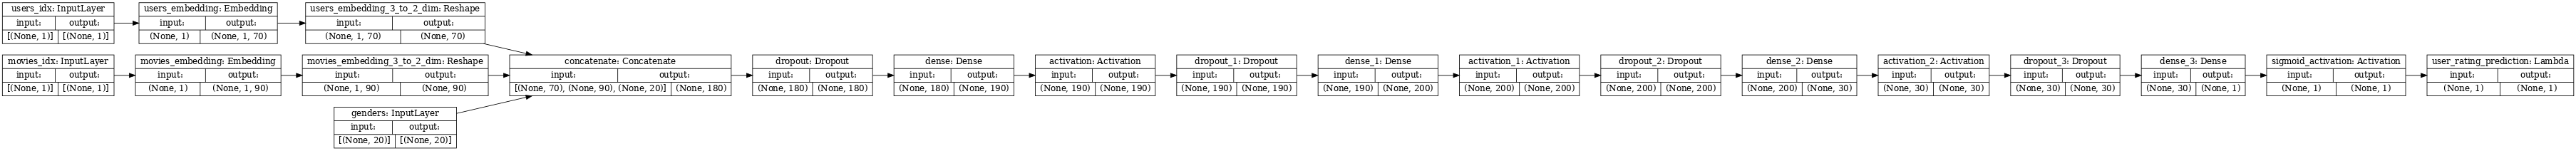

In [43]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
plot_model(tuner.hypermodel.build(best_hps))

In [44]:
# model.summary()

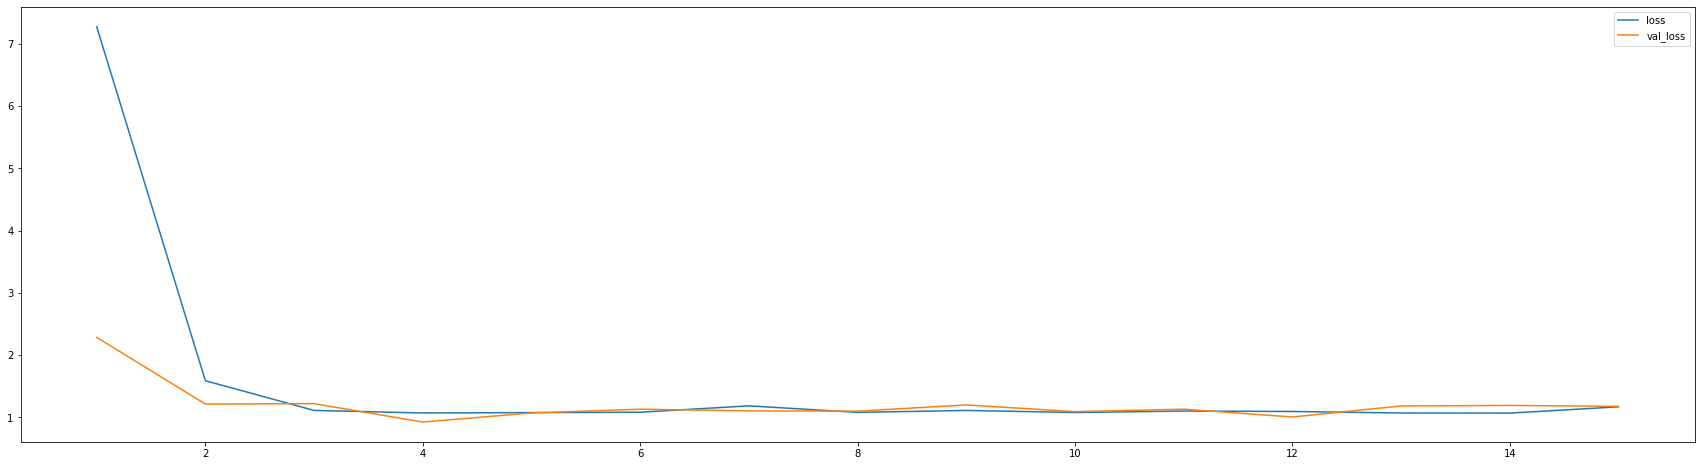

 52/100 [==============>...............] - ETA: 0s - loss: 1.0947

Evaluate model each 51 steps(Batch-size: 211):
1/1 [==============================] - 0s 11ms/step - loss: 1.0367

Val metrics:
  - Loss (16): 1.036702 (⟱ 0.14144647)

Continue model train:
100/100 [==============================] - 1s 10ms/step - loss: 1.0913 - val_loss: 1.0902


In [45]:
model    = tuner.hypermodel.build(best_hps)

history = model.fit_generator(
    generator=train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=[
        create_metrics_callback(), 
        create_checkpoints_callback(),
        EarlyStopping(monitor='val_loss', patience=5)
    ],
    use_multiprocessing=True,
    verbose=1
)

In [46]:
evaluate(model, train_set, batch_size=train_batch_size)

1.1712768077850342

In [47]:
evaluate(model, val_set, batch_size=val_batch_size)

1.1873587369918823

In [48]:
evaluate(model, test_set, batch_size=val_batch_size)

0.9119779467582703

In [49]:
val_loss_per_epoch = history.history['val_loss']

best_epoch = val_loss_per_epoch.index(min(val_loss_per_epoch)) + 1

print(f'Best epoch: {best_epoch}')

Best epoch: 3


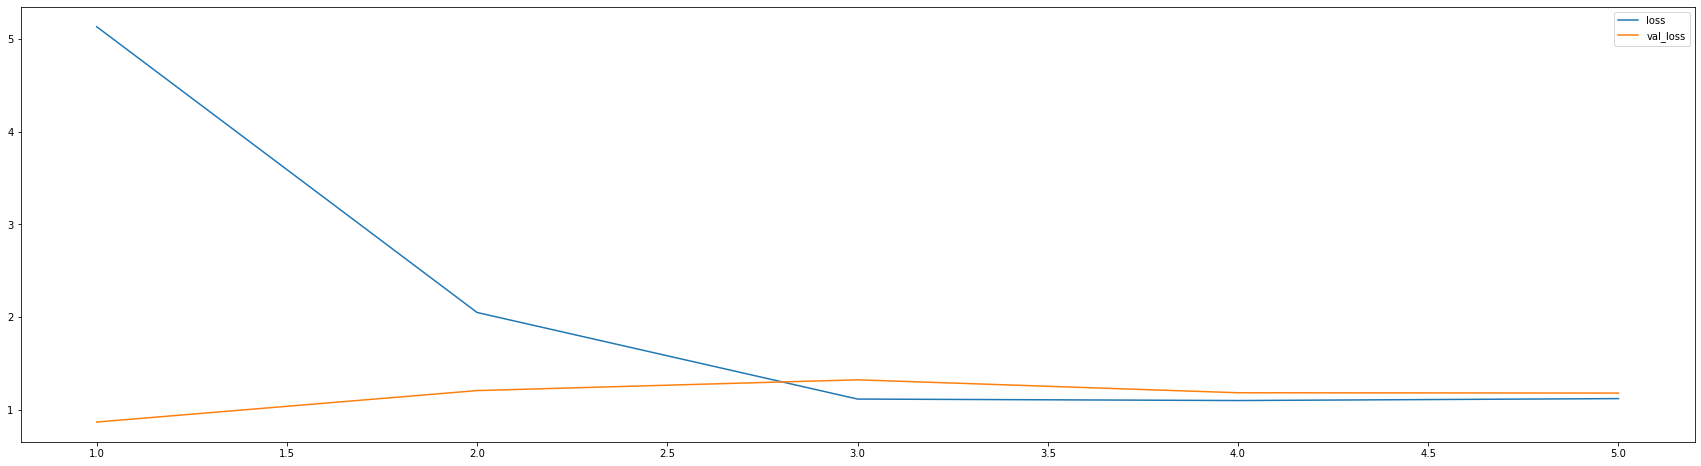

 52/100 [==============>...............] - ETA: 0s - loss: 1.0730

Evaluate model each 51 steps(Batch-size: 211):
1/1 [==============================] - 0s 13ms/step - loss: 1.2423

Val metrics:
  - Loss (6): 1.242331 (⟰ 0.06222761)

Continue model train:
100/100 [==============================] - 1s 12ms/step - loss: 1.0924 - val_loss: 1.0904


In [50]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
model    = tuner.hypermodel.build(best_hps)

history = model.fit_generator(
    generator=train_generator,
    validation_data=val_generator,
    epochs=best_epoch,
    callbacks=[
        create_metrics_callback(), 
        create_checkpoints_callback(),
        EarlyStopping(monitor='val_loss', patience=5)
    ],
    use_multiprocessing=True,
    verbose=1
)

In [51]:
evaluate(model, train_set, batch_size=train_batch_size)

1.053186297416687

In [52]:
evaluate(model, val_set, batch_size=val_batch_size)

1.1017273664474487

In [53]:
evaluate(model, test_set, batch_size=val_batch_size)

1.4651832580566406

## Check rating prediction

In [54]:
dataset_size = 'ml-latest' # 250MB
# dataset_size = 'ml-25m' # 25MB
# dataset_size = 'ml-latest-small' # 1MB

In [55]:
from data import MovieLensDataSource

ds = MovieLensDataSource(size = dataset_size)

dataset = ds.dataset()

In [56]:
random.choice?

Object `random.choice` not found.


In [57]:
train_set[['user_seq']]

,user_seq
0,0
1,1
2,2
3,3
4,4
...,...
70456,32
70457,193
70458,156
70459,13


Predict ratings used to train model:

In [58]:
import random

class Dataset:
    def __init__(self, samples):
        self.samples = samples
 
    def searchBySeqs(self, user_seq, movie_seq): 
        return self.samples[(self.samples.user_seq == user_seq) & (self.samples.movie_seq == movie_seq)]

    def searchRandom(self,  has_rating=True):
        """
        Get a pair used, movie index used to query roes under a dataset.
        """
        finish = True
        while finish:
            user_seq = random.choice(self.samples['user_seq'])
            movie_seq = random.choice(self.samples['movie_seq'])
        
            sample = self.searchBySeqs(user_seq, movie_seq)
    
            finish = sample.empty if has_rating else not sample.empty

        return sample.head(1)

    
def predict(model, samples, batch_size):
    X, y = samples[list(set(samples.columns) - set(['user_id', 'movie_id', 'rating']))].values, samples['rating'].values
 
    generator = InMemoryXyDataGenerator(
        X,
        y, 
        batch_size,
        shuffle=True, 
        to_input=to_input
    )
    X_batch, y_batch = generator[0]
    
    
    y_predicted = model.predict(X_batch, batch_size=batch_size, verbose=0)
 
    result = samples.copy()
    result.insert(0, 'pred_rating', y_predicted) 
    return result 

def to_percent(value): return round(value * 100, 2)

def get_metrics(train_dataset, max_error = 1, sample_size = 1000):    
    true_positives = false_positives = 0
    error_dits = []

    for index in range(0, sample_size):
        train_sample = train_dataset.searchRandom()
        result = predict(model, train_sample, batch_size=train_sample.shape[0])

        error = abs(result['pred_rating'].item() - result['rating'].item())
        error_dits.append(error)

        if  error <= max_error:
            true_positives +=1
        else:
            false_positives +=1
        print('.', end='')

    return {
        'true_positives': f'{to_percent(true_positives / sample_size)}%',
        'false_positives':  f'{to_percent(false_positives / sample_size)}%',
        'error_dist': error_dits
    }

train_dataset = Dataset(train_set)
val_dataset = Dataset(val_set)
test_dataset = Dataset(test_set)

In [59]:
train_metrics = get_metrics(train_dataset)
{k: train_metrics[k] for k in ('true_positives', 'false_positives')}

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

{'true_positives': '70.3%', 'false_positives': '29.7%'}

In [60]:
val_metrics = get_metrics(val_dataset)
{k: val_metrics[k] for k in ('true_positives', 'false_positives')}

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

{'true_positives': '73.6%', 'false_positives': '26.4%'}

In [ ]:
test_metrics = get_metrics(test_dataset)
{k: test_metrics[k] for k in ('true_positives', 'false_positives')}

...................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................